In [1]:
% Path variables which are necessary
addpath([pwd filesep 'libsvm']);

% Some variables used to make pretty plots
col = [0.9047    0.1918    0.1988
    0.2941    0.5447    0.7494
    0.3718    0.7176    0.3612
    1.0000    0.5482    0.1000
    0.4550    0.4946    0.4722
    0.6859    0.4035    0.2412
    0.9718    0.5553    0.7741
    0.5313    0.3359    0.6523];

col = repmat(col,2,1);
col_fill = col;
col(9:end,:) = 0; % when plotting > 8 items, we make the outline black

marker = {'d','+','o','x','>','s','<','+','^'};
marker = repmat(marker,1,2);
ms = 12;
savefigflag=0;

In [2]:
svm_path = which('svmtrain');

fprintf('\n');
if strfind(lower(svm_path),'.mex') > 0
    fprintf('The path for svmtrain is: %s\n',svm_path);
    fprintf('libsvm is loaded properly! Carry on!\n');
else
    fprintf('Could not find LIBSVM. Make sure it''s added to the path.\n');
end

The path for svmtrain is: C:\Users\alistair\Documents\mimic-workshop\mlcc\lab2-intro-ml\libsvm\svmtrain.mexw64
libsvm is loaded properly! Carry on!

In [ ]:
% Option 1. This loads fisher iris instead of the ICU data
load fisheriris;
X = meas(:,1:3);
X_header = {'Sepal length','Sepal width','Petal length'};
y = double(strcmp(species,'virginica')==1);
clear meas species;

In [ ]:
% Option 2. Extract the patient data using the query from your assignment
% Run the following to connect to the database

% STEP 1: Tell Matlab where the driver is
javaclasspath('sqlite-jdbc-3.8.11.2.jar') % use this for SQLite

% STEP 2: Connect to the Database
if exist('conn','var') != 1
conn = database('','','',...
    'org.sqlite.JDBC',['jdbc:sqlite:' pwd filesep 'data' filesep 'mimiciii_v1_3_demo.sqlite']);
end

% Option 2 (continued). Extract the patient data using the query from your assignment
% At the moment this query is long, and takes ~5 minutes
setdbprefs('DataReturnFormat','dataset')
query = makeQuery('mlcc1-problem-set-solutions.sql');
data = fetch(conn,query);

% now convert data to a cell array
data = dataset2cell(data);

% we can get the column names from the first row of the 'data' variable
header = data(1,:);
header{2} = 'OUTCOME';
header = regexprep(header,'_',''); % remove underscores
data = data(2:end,:);

% MATLAB sometimes reads 'null' instead of NaN
data(cellfun(@isstr, data) & cellfun(@(x) strcmp(x,'null'), data)) = {NaN};

% MATLAB sometimes has blank cells which should be NaN
data(cellfun(@isempty, data)) = {NaN};

% Convert the data into a matrix of numbers
% This is a MATLAB data type thing - we can't do math with cell arrays
data = cell2mat(data);

X = data(:,3:5);
X_header = header(3:5);
y = data(:,2);

In [3]:
% (Option 3) Load the ICU data from the .mat file provided

% Loads in 'X', 'X_header', and 'y' variables
load('MLCCData.mat'); 

X = data(:,3:5);
X_header = header(3:5);
y = data(:,2);

In [12]:
% Data will have at least three columns: 
%   ICUSTAY_ID, OUTCOME, AGE

% the following loops display the data nicely
W = 5; % the maximum number of columns to print at one time
for o=1:floor(size(data,2)/W)
    idxColumn = (o-1)*W + 1 : o*W;
    if idxColumn(end) > size(data,2)
        idxColumn = idxColumn(1):size(data,2);
    end
    
    fprintf('%12s\t',header{idxColumn});
    fprintf('\n');
    for n=1:5
        for m=idxColumn
            fprintf('%12g\t',data(n, m));
        end
        fprintf('\n');
    end
    fprintf('\n');
end

ICUSTAYID	     OUTCOME	         Age	HeartRateMin	HeartRateMax	
      230834	           0	     23.6137	         111	         122	
      284549	           0	     86.7196	          59	          76	
      204985	           0	     74.2264	          70	          83	
      261097	           0	     51.3441	          91	          91	
      219258	           0	     51.4133	          58	         118	

   MeanBPMin	   MeanBPMax	 RespRateMin	 RespRateMax	      GCSMin	
          59	          64	          12	          22	          15	
          55	         108	          15	          25	          15	
     47.3333	          65	          12	          20	          15	
          87	          87	          19	          19	         NaN	
          59	     123.667	           9	          31	           8	

      GCSMax	BILIRUBINmin	BILIRUBINmax	CREATININEmin	CREATININEmax	
          15	         NaN	         NaN	         0.8	           1	
          15	         0.5	         0.5	         0.6	         0.7	
         

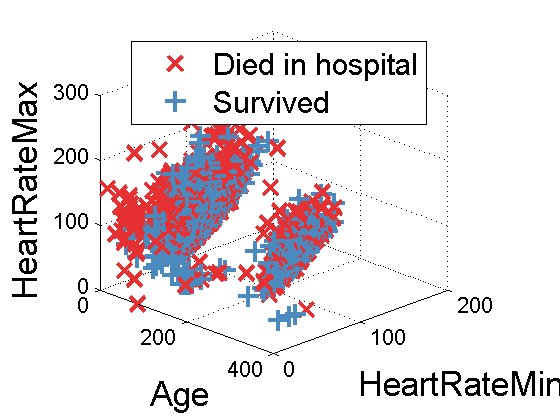

In [13]:
% Before we train a model - let's inspect the data
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

figure(1); clf; hold all;
plot3(X(idxTarget,1),X(idxTarget,2),X(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:)...
    ,'MarkerSize',10,'LineWidth',2);
plot3(X(~idxTarget,1),X(~idxTarget,2),X(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:)...
    ,'MarkerSize',10,'LineWidth',2);
grid on;

xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
legend({'Died in hospital','Survived'},'FontSize',14);
set(gca,'view',[45 25]); % a nice isometric view

% 1) What do you see that is notable?
% ANSWER: for the ICU data...
%   there are ages ~ 300, these are de-identified ages
%   patients with a minimum heart rate of 0 appear more likely to die
%   patients with "extreme" data (outside the massive blob in the middle) seem more likely to die

In [14]:
% Correct the erroneous ages
% Hint: the median age of patients > 89 is 91.6.
X( X(:,1) > 89, 1 ) = 91.6;

In [15]:
% Normalize the data!
% First get the column wise mean and the column wise standard deviation
mu = nanmean(X, 1);
sigma = nanstd(X, [], 1);

% Now subtract each element of mu from each column of X
X = bsxfun(@minus, X, mu);
X = bsxfun(@rdivide, X, sigma);

In [16]:
% We will be using libsvm. If you call svmtrain on its own, it lists the options available
svmtrain;

Invalid MEX-file 'C:\Users\alistair\Documents\mimic-workshop\mlcc\lab2-intro-ml\libsvm\svmtrain.mexw64': The specified procedure could not be found.


In [ ]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y, X, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
pred = svmpredict(y, X, model_linear);

In [ ]:
% Evaluate the model - plot a confusion matrix


In [ ]:
% Now let's try with an RBF kernel
% This is LIBSVM's most flexible kernel
% We specify it as '-t 2'

% train the model
model_rbf = svmtrain(y, X, '-t 2');

% Apply the classifier to the data set
pred = svmpredict(y, X, model_rbf);

In [ ]:
% Evaluate the RBF model - plot a confusion matrix


In [ ]:
% Directly compare the RBF model with the linear model


In [ ]:
% Plot the RBF model and the linear model together



In [ ]:
% Specify parameters in the RBF kernel
% The RBF kernel has some parameters of its own: gamma and capacity
% Let's set these to a different value then their defaults

gamma = 2;
capacity = -1;

% train the model
model_rbf = svmtrain(y, X, ['-t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);
pred = svmpredict(y, X, model_rbf);

In [ ]:
% Optimize the RBF kernel
% Let's see how much better we can make our model!
% change gamma below to try and improve your performance
% Keep it as an integer!

gamma = 20;
capacity = 1;

%% train the model
model_rbf = svmtrain(y, X, ['-t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);
pred = svmpredict(y, X, model_rbf);